In [33]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pickle
import numpy as np

import crflux.models as pm
import mceq_underground_helpers_cs as mh
from MCEq.data import InteractionCrossSections
from MCEq.core import MCEqRun
import  mceq_underground_helpers_oneregion as helper


In [34]:
cs_p_values = [1.0,1.01] #[0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]  # List of cross-section values: pion-air
cs_k_values = [1.00]
ptype_values = [2212] 
season_values = ["jan", "apr", "jul"]  #  seasons
e0_values = [2.05,2.15,2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95,3.05,3.15,3.25,3.35,3.45,3.55,3.65,3.75,3.85,3.95,4.05,4.15,4.25,4.35,4.45,4.55,4.65,4.75,4.85]
e1_values = [2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95,3.05,3.15,3.25,3.35,3.45,3.55,3.65,3.75,3.85,3.95,4.05,4.15,4.25,4.35,4.45,4.55,4.65,4.75,4.85,4.95,5.05]
pairwise = True


helper.initialize_flux_dicts(
        ptype_values, cs_p_values, cs_k_values, e0_values, e1_values if 'e1_values' in locals() else [None], pairwise=pairwise
) 

helper.some_function_that_uses_angles()
angles = helper.angles
X = helper.slant_depths[2:-1:4]


In [35]:
plot_dir = '/hetghome/khymon/Plots/cs-analysis/'

In [36]:
# get pion cross section
mceq_instance = MCEqRun(
        interaction_model="SIBYLL23C",
        theta_deg=0.0,
        primary_model=(pm.GlobalSplineFitBeta, None),
        density_model = ('MSIS00_IC',('South Pole','January')),
    )


cs_pion = InteractionCrossSections(mceq_instance._mceq_db, interaction_model="SIBYLL23C").get_cs(211, mbarn=True)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('South Pole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_primary_model(): GlobalSplineFitBeta 


In [37]:
# Load the pickle file - see file with fixed norm 4.05 in same folder, here norm is changed according to current e0
#default order: (str(d), str(cs_p1), str(cs_p2), str(cs_k2), str(ptype), season, str(e0))

# normalization flag
norm = False

if norm:

    with open("/hetghome/khymon/cs-files/R_value_const_pi-air_k-air_sibyll23c_smooth_oneregion_energybin_test.pkl", "rb") as file:
        data = pickle.load(file)

else:
    with open("/hetghome/khymon/cs-files/R_value_const_pi-air_k-air_sibyll23c_smooth_oneregion_energybin_test_nonorm.pkl", "rb") as file:
        data = pickle.load(file)

# Print or inspect the data
print(data)

{('1.5', '1.0', '1.0', '2212', 'jan', '2.05', 'inf'): array([4.48226310e-05, 4.85627721e-05, 5.28496790e-05, 5.83037731e-05,
       6.49225780e-05, 7.28977514e-05]), ('1.5', '1.0', '1.0', '2212', 'apr', '2.05', 'inf'): array([4.84124814e-05, 5.24411267e-05, 5.70397214e-05, 6.25745447e-05,
       6.96276325e-05, 7.79682006e-05]), ('1.5', '1.0', '1.0', '2212', 'jul', '2.05', 'inf'): array([5.23442020e-05, 5.63753157e-05, 6.12945583e-05, 6.65843833e-05,
       7.35814095e-05, 8.18216528e-05]), ('1.5', '1.01', '1.0', '2212', 'jan', '2.05', '2.25'): array([4.48226310e-05, 4.85627721e-05, 5.28496790e-05, 5.83037731e-05,
       6.49225780e-05, 7.28977514e-05]), ('1.5', '1.01', '1.0', '2212', 'jan', '2.15', '2.35'): array([4.48226310e-05, 4.85627721e-05, 5.28496790e-05, 5.83037731e-05,
       6.49225781e-05, 7.28977515e-05]), ('1.5', '1.01', '1.0', '2212', 'jan', '2.25', '2.45'): array([4.48226310e-05, 4.85627721e-05, 5.28496790e-05, 5.83037717e-05,
       6.49225714e-05, 7.28977360e-05]), ('1

In [38]:
e0_values = [2.15,2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95,3.05,3.15,3.25,3.35,3.45,3.55,3.65,3.75,3.85,3.95,4.05,4.15,4.25,4.35,4.45,4.55,4.65,4.75,4.85,4.95] #energy bin where the modification is applied

log_e_bins = np.log10(mceq_instance.e_bins)  # Convert edges to log scale
bin_centers = 0.5 * (log_e_bins[:-1] + log_e_bins[1:])  # Midpoints of log bins
indices = np.searchsorted(bin_centers, e0_values)
cs_pion_selected = cs_pion[indices]

In [39]:
def get_data(fixed_params):
    # Define the e0_values list to iterate over
    e0_values_list = ['2.05', '2.15', '2.25', '2.35', '2.45', '2.55', '2.65', '2.75', '2.85', '2.95', 
                      '3.05', '3.15', '3.25', '3.35', '3.45', '3.55', '3.65', '3.75', '3.85', '3.95', 
                      '4.05', '4.15', '4.25', '4.35', '4.45', '4.55', '4.65', '4.75', '4.85','4.95','5.05']
    
    # Collect data for each e0_value
    sel_data = [data[(fixed_params[0], fixed_params[1], "1.0", "2212", "apr", e0_values_list[e0],e0_values_list[e0+2])] for e0 in range(len(e0_values_list)-2)]

    return np.array(sel_data)

In [40]:
data_15_csp101 = get_data(("1.5", "1.01"))
data_35_csp101 = get_data(("3.5", "1.01"))


In [41]:
print(list(data.keys())[:5]) 

[('1.5', '1.0', '1.0', '2212', 'jan', '2.05', 'inf'), ('1.5', '1.0', '1.0', '2212', 'apr', '2.05', 'inf'), ('1.5', '1.0', '1.0', '2212', 'jul', '2.05', 'inf'), ('1.5', '1.01', '1.0', '2212', 'jan', '2.05', '2.25'), ('1.5', '1.01', '1.0', '2212', 'jan', '2.15', '2.35')]


In [42]:
R_def_15 = data[('1.5', '1.0', '1.0', '2212', 'apr', '2.05', 'inf')]  
R_def_35 = data[('3.5', '1.0', '1.0', '2212', 'apr', '2.05', 'inf')]  



In [43]:
data_15_csp101.shape
cs_pion_selected.shape

(29,)

In [44]:
def dRdSig(R_array,cs_pion):

    slope = np.ndarray(shape=((len(e0_values)-2),6)) 

    for i in range(len(e0_values)-2):
        R1 = R_array[i]
        R2 = R_array[i+1]
        
        slope[i] = (R2-R1)/(0.01*cs_pion[i])

    return slope

In [45]:
dRdsig_15_cs101 = dRdSig(data_15_csp101,cs_pion_selected) # need to know energy bin here
dRdsig_35_cs101 = dRdSig(data_35_csp101,cs_pion_selected)

In [51]:
# Get six evenly spaced colors from the 'inferno' colormap
cmap = plt.get_cmap("inferno")
colors = [cmap(i) for i in np.linspace(0, 0.85, 6)]  # Max at 0.85 to avoid bright yellow

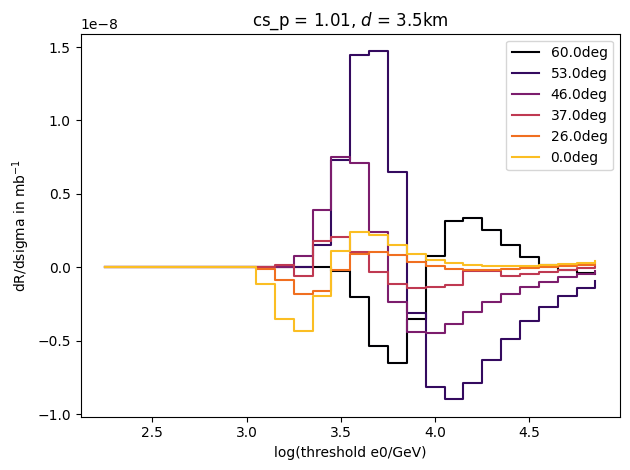

In [52]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], dRdsig_35_cs101[:,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 3.5km')
plt.ylabel('dR/dsigma in mb$^{-1}$')
#plt.yscale('log')
plt.legend()
plt.tight_layout()
if norm:
    plt.savefig(plot_dir + 'dRdsgima_csp1.01_depth3.5_renormed_current_e0_1bin.png')
else:
    plt.savefig(plot_dir + 'dRdsgima_csp1.01_depth3.5_renormed_current_e0_1bin_nonorm.png')

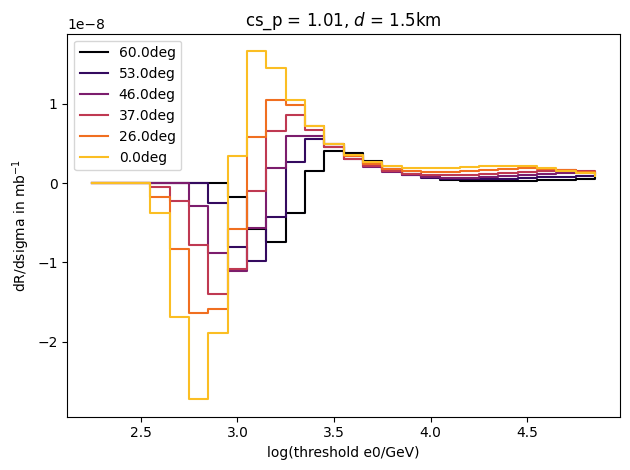

In [53]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], dRdsig_15_cs101[:,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 1.5km')
plt.ylabel('dR/dsigma in mb$^{-1}$')
#plt.yscale('log')
plt.legend()
plt.tight_layout()
#plt.ylim(-0.05,0.05)
if norm:
    plt.savefig(plot_dir + 'dRdsgima_csp1.01_depth1.5_renormed_current_e0_1bin.png')
else:
    plt.savefig(plot_dir + 'dRdsgima_csp1.01_depth1.5_renormed_current_e0_1bin_nonorm.png')

/tmp/ipykernel_3776832/2888060439.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot(e0_values[1:-1], dRdsig_35_cs101[:,j]**(-1), drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])


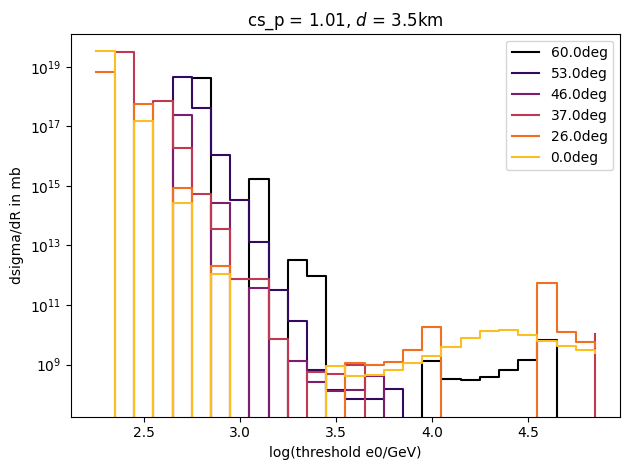

In [54]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], dRdsig_35_cs101[:,j]**(-1), drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg',color=colors[j])

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 3.5km')
plt.ylabel('dsigma/dR in mb')
plt.yscale('log')
plt.legend()
plt.tight_layout()
#plt.ylim(-0.03,0.03)
if norm:
    plt.savefig(plot_dir + 'dsgimadR_csp1.01_depth3.5_renormed_current_e0_1bin.png')
else:
    plt.savefig(plot_dir + 'dsgimadR_csp1.01_depth3.5_renormed_current_e0_1bin_nonorm.png')

In [55]:
dRdsig_35_cs101[:,j]**(-1)

array([ 3.40358797e+19, -3.61761070e+18,  1.56877848e+17, -1.66061991e+16,
        2.73700046e+14, -3.71486754e+13,  1.07976951e+12, -1.10966451e+11,
       -8.84826611e+08, -2.81066042e+08, -2.30390252e+08, -5.14628093e+08,
        8.96103213e+08,  4.15474724e+08,  4.61922553e+08,  6.64962769e+08,
        1.08423232e+09,  1.96893551e+09,  3.89554800e+09,  8.04150193e+09,
        1.38791943e+10,  1.41948542e+10,  9.46666187e+09,  6.09256405e+09,
        4.24756149e+09,  3.16524673e+09,  2.50942931e+09])

how does R change with changing threshold

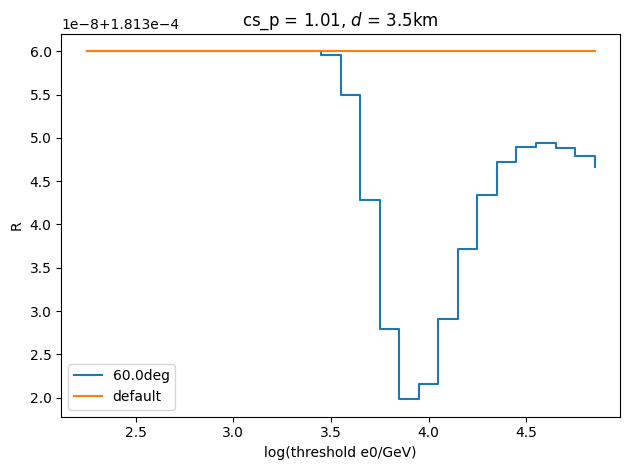

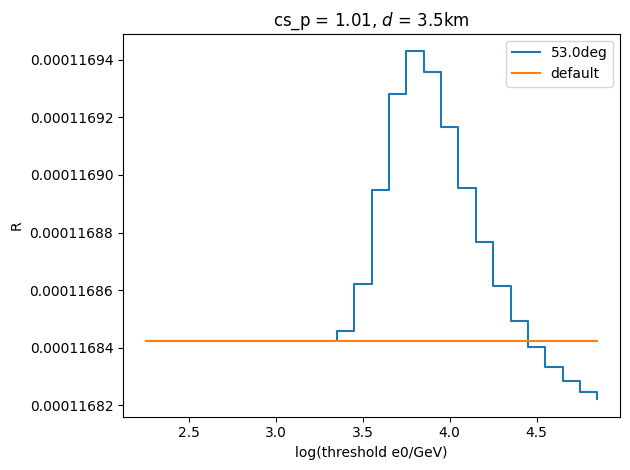

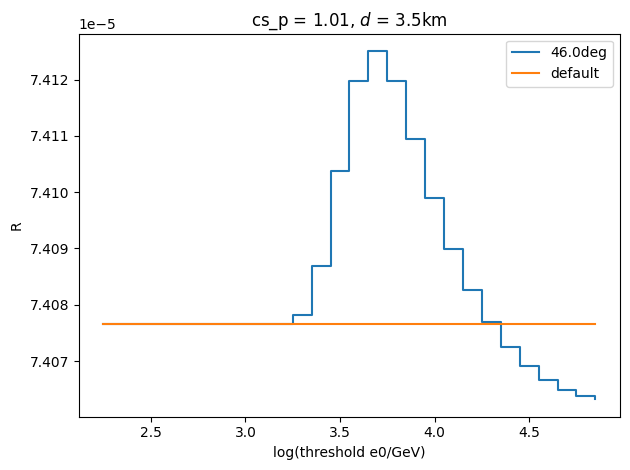

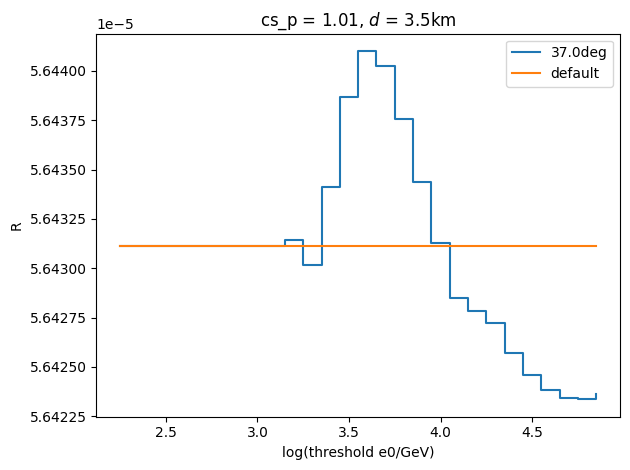

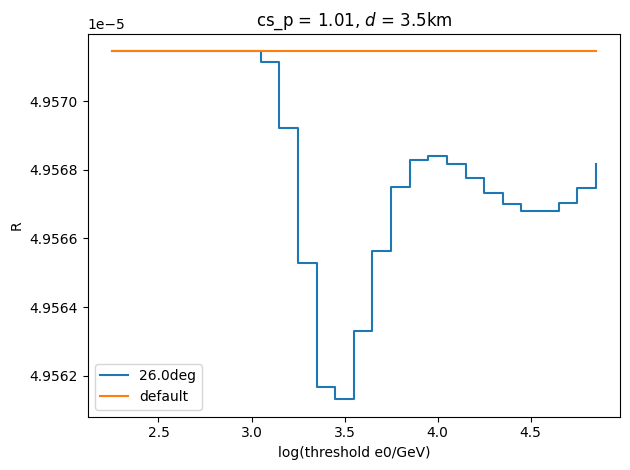

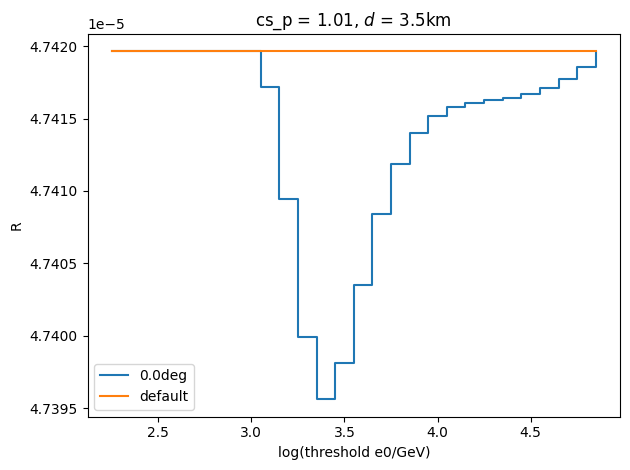

<Figure size 640x480 with 0 Axes>

In [61]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], data_35_csp101[1:-1,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')
    plt.plot(e0_values[1:-1],R_def_35[j]*np.ones(len(e0_values[1:-1])),label='default')

    # Add labels and title
    plt.xlabel('log(threshold e0/GeV)')
    plt.title('cs_p = 1.01, $d$ = 3.5km')
    plt.ylabel('R')
    #plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    if norm:
        plt.savefig(plot_dir + 'E_R_csp1.01_depth3.5_renormed_current_e0_1bin_'+ str(np.round(angles[j],decimals=0)) +'deg.png')
    else:
        plt.savefig(plot_dir + 'E_R_csp1.01_depth3.5_renormed_current_e0_1bin_nonorm_'+ str(np.round(angles[j],decimals=0)) +'deg.png')
    plt.show()
    plt.clf()

In [62]:
for j in range(len(angles)):
    plt.plot(e0_values[1:-1], data_15_csp101[1:-1,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')
    plt.plot(e0_values[1:-1],R_def_15[j]*np.ones(len(e0_values[1:-1])),label='default')

    # Add labels and title
    plt.xlabel('log(threshold e0/GeV)')
    plt.title('cs_p = 1.01, $d$ = 1.5km')
    plt.ylabel('dR/dsigma in mb$^{-1}$')
    #plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    if norm:
        plt.savefig(plot_dir + 'E_R_csp1.01_depth1.5_renormed_current_e0_1bin_' + str(np.round(angles[j],decimals=0)) +'.png')
    else:
        plt.savefig(plot_dir + 'E_R_csp1.01_depth1.5_renormed_current_e0_1bin_nonorm' + str(np.round(angles[j],decimals=0)) +'.png')
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [34]:
X = helper.slant_depths[2:-1:4]

In [64]:
helper.mult_dist(X,0.,pm.GlobalSplineFitBeta(),"yields_apr",
                        2212,
                        1.01, 1.0, 2.25,2.45,
                        norm=False)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

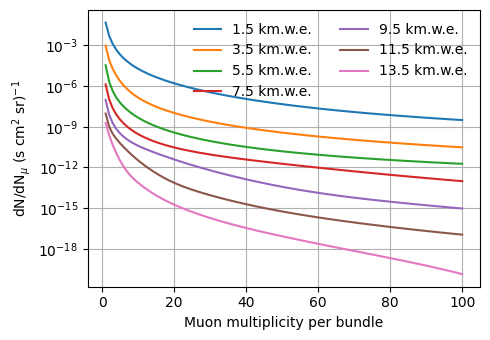

In [71]:
# understand figures
import mceq_underground_helpers_oneregion as mhh
cs_k = 1.0



plt.figure(figsize=(5.0, 3.5))
lines=[]
angle = 0.0
for X in mh.slant_depths[2:-1:4]:
    plt.semilogy(
        mh.n_mu_vec,
        1e4*mhh.mult_dist(X,
                        0.,
                        pm.GlobalSplineFitBeta(),"yields_apr",
                        2212,
                        1.01, cs_k, 2.25,2.45,
                        norm=False#))[0]
                    ) / mhh.rates(X, angle, "apr", 2212, 1.01, cs_k, 2.25,2.45),
        #c=s_m.to_rgba(X), #
        label=r"{0:3.1f} km.w.e.".format(X),
    )[0]

   
    
plt.xlabel("Muon multiplicity per bundle")
plt.ylabel(r"dN/dN$_\mu$ (s cm$^2$ sr)$^{-1}$")
lines.append(mlines.Line2D([], [], color='k', linestyle="--", label="jul"))
plt.legend(handles=lines, frameon=False, loc="lower left")
plt.legend(frameon=False, ncol=2)
# plt.ylim(1e-11, 8e-5)
# plt.xlim(4,100)

plt.grid()
plt.tight_layout()

#plt.savefig(plot_dir + 'multiperbundle_season.png')

In [ ]:
# get ratio to default